In [19]:
import rdkit
from torch_geometric.datasets import MoleculeNet
import seaborn as sns
import numpy as np
import pandas as pd
from IPython.display import clear_output
from scipy.spatial import cKDTree
import torch
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from torch import nn
import torch_geometric.nn as geom_nn
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, TensorDataset
import copy

In [43]:
def particle_shift(particles,shift=10):

    ### Y shift ###
    y_pos = particles.copy()
    y_pos["y"] = particles["y"]+shift

    y_neg = particles.copy()
    y_neg["y"] = particles["y"]-shift

    ### Z shift ###
    z_pos = particles.copy()
    z_pos["z"] = particles["z"]+shift

    z_neg = particles.copy()
    z_neg["z"] = particles["z"]-shift

    ### Diagonal shifts ###
    ### y_pos_z_pos ###
    y_pos_z_pos = particles.copy()
    y_pos_z_pos["y"] = particles["y"]+shift
    y_pos_z_pos["z"] = particles["z"]+shift

    ### y_pos_z_neg ###
    y_pos_z_neg = particles.copy()
    y_pos_z_neg["y"] = particles["y"]+shift
    y_pos_z_neg["z"] = particles["z"]-shift

    ### y_neg_z_pos ###
    y_neg_z_pos = particles.copy()
    y_neg_z_pos["y"] = particles["y"]-shift
    y_neg_z_pos["z"] = particles["z"]+shift

    ### y_neg_z_neg ###
    y_neg_z_neg = particles.copy()
    y_neg_z_neg["y"] = particles["y"]-shift
    y_neg_z_neg["z"] = particles["z"]-shift

    return pd.concat([particles,y_pos,y_neg,z_pos,z_neg,y_pos_z_pos,y_pos_z_neg,y_neg_z_pos,y_neg_z_neg])

### array Differences function ###

def array_difference(array1,array2):
    ### First one must be the bigger array ###
    set1 = set(map(tuple, array1))
    set2 = set(map(tuple, array2))
    
    # Find the set difference
    set_difference = set1 - set2

    # Convert the set difference back to a NumPy array
    return np.array(list(set_difference))

def add_const_parameter(data,const_param):

    ### Given a numpy array of size m*n , it will return a numpy array of size m*(n+1), where
    ### the last column has all elements as const_param ###

    add_column = np.ones(len(data))*const_param
    
    return np.hstack((data, add_column[:,None]))


def mirror_edge_index(edge_index):

    first_row = edge_index[0:1, :]
    second_row = edge_index[1:, :]
    output_tensor = np.concatenate((second_row, first_row), axis=0)
    
    return np.concatenate((edge_index,output_tensor),axis=1)


def weighted_averaging(data):
    
    idx = np.where(data[0][:,4]==0)[0]
    deg_1 = data[0][idx,1:4].sum()

    idx = np.where(data[0][:,4]==1)[0]
    deg_2 = data[0][idx,1:4].sum()

    idx = np.where(data[0][:,4]==2)[0]
    deg_3 = data[0][idx,1:4].sum()

    return deg_1 + 0.5*deg_2 + 0.25*deg_3 


def merge_columns_to_pandas_list(pandas_list,variable_list,master_dataframe):

    """ given a list of pandas dataframe with the x,y,z locations and re and phi ,this function will
        merge each pandas dataframe from the list with the master dataframe with all the columns  
    """

    joined = copy.deepcopy(pandas_list)

    for i in range(len(joined)):
        print("Particle number : ",str(i+1))
        
        temp = copy.deepcopy(joined[i])
        # print("Unjoined" , temp)
        add = pd.merge(temp,master_dataframe,how="inner",on=['Center_x','Re'],sort=False)[variable_list]
        joined[i] = pd.concat([temp,add], axis=1)
        # print("Joined" , joined[i])
        clear_output(wait=True)
        
    return joined


def generator(all_particles,dev_particles,sf,master_dataframe):

    ### Given the pandas data of developed particles and all the particles including the particle shifted for periodicity ###
    ### This functions works for one dataset for a particular solid fraction at a time ###
    ### Master dataframe for the particular aspect ratio needs to be input to combine with the other 
    
    tree = cKDTree(all_particles.values)
    idx = np.stack([tree.query(dev_particles.iloc[i][["x","y","z"]].values,16)[1] for i in range(len(dev_particles))])
    input_dat = np.stack([all_particles.iloc[idx[i]] for i in range(len(idx))])

    ### Adding solid fraction column ###
    input_dat = [add_const_parameter(input_dat[i],sf) for i in range(len(input_dat))]

    ### Adding 4 Reynolds numbers and combining the datasets ###
    input_dat = np.vstack( ( np.stack( [add_const_parameter(input_dat[i],10) for i in range(len(input_dat))] ),
                              np.stack( [add_const_parameter(input_dat[i],50) for i in range(len(input_dat))] ),
                              np.stack( [add_const_parameter(input_dat[i],50) for i in range(len(input_dat))] ),
                              np.stack( [add_const_parameter(input_dat[i],50) for i in range(len(input_dat))] ),
                    ) )
    input_dat = [ pd.DataFrame( input_dat[i],columns=["Center_x","Center_y","Center_z","Phi","Re"]) for i in range(len(input_dat)) ]
    
    ### Joing with df array to get inclination and drag and other quantities if needed ###
    input_dat = merge_columns_to_pandas_list(pandas_list=input_dat ,variable_list=["Inclination_angle","Drag_local"],master_dataframe=master_dataframe)
    input_dat = [ np.concatenate( (input_dat[i][["Center_x","Center_y","Center_z","Inclination_angle"]].values.flatten()
                                       ,input_dat[i].iloc[0][["Phi","Re","Drag_local"]].values) )  for i in range(len(input_dat))]

    return input_dat

In [21]:
### Ar=5 Sf=0.1 case 1 ###
np.save("all_particle_data_files/center_phi_10_5_case_1.dat",
all_particles_5[(all_particles_5["phi"]==10)&(all_particles_5["case"]==2)&(all_particles_5["Re"]==10)].values[:,2:11])

### Ar=5 Sf=0.1 case 2 ###
np.save("all_particle_data_files/center_phi_10_5_case_2.dat",
all_particles_5[(all_particles_5["phi"]==10)&(all_particles_5["case"]==3)&(all_particles_5["Re"]==10)].values[:,2:11])

### Ar=5 Sf=0.2 case 1 ###
np.save("all_particle_data_files/center_phi_20_5_case_1.dat",
all_particles_5[(all_particles_5["phi"]==20)&(all_particles_5["case"]==1)&(all_particles_5["Re"]==10)].values[:,2:11])

### Ar=5 Sf=0.2 case 2 ###
np.save("all_particle_data_files/center_phi_20_5_case_2.dat",
all_particles_5[(all_particles_5["phi"]==20)&(all_particles_5["case"]==3)&(all_particles_5["Re"]==10)].values[:,2:11])

### Ar=5 Sf=0.3 case 1 ###
np.save("all_particle_data_files/center_phi_30_5_case_1.dat",
all_particles_5[(all_particles_5["phi"]==30)&(all_particles_5["case"]==1)&(all_particles_5["Re"]==10)].values[:,2:11])

### Ar=5 Sf=0.3 case 2 ###
np.save("all_particle_data_files/center_phi_30_5_case_2.dat",
all_particles_5[(all_particles_5["phi"]==30)&(all_particles_5["case"]==2)&(all_particles_5["Re"]==10)].values[:,2:11])

In [22]:
### Ar=10 Sf=0.1 case 1 ###
np.save("all_particle_data_files/center_phi_10_10_case_1.dat",
all_particles_10[(all_particles_10["phi"]==10)&(all_particles_10["case"]==1)&(all_particles_10["Re"]==10)].values[:,2:11])

### Ar=10 Sf=0.1 case 2 ###
np.save("all_particle_data_files/center_phi_10_10_case_2.dat",
all_particles_10[(all_particles_10["phi"]==10)&(all_particles_10["case"]==2)&(all_particles_10["Re"]==10)].values[:,2:11])

# ### Ar=10 Sf=0.15 case 1 ###
np.save("all_particle_data_files/center_phi_15_10_case_1.dat",
all_particles_10[(all_particles_10["phi"]==15)&(all_particles_10["case"]==1)&(all_particles_10["Re"]==10)].values[:,2:11])

# ### Ar=10 Sf=0.15 case 2 ###
np.save("all_particle_data_files/center_phi_15_10_case_2.dat",
all_particles_10[(all_particles_10["phi"]==15)&(all_particles_10["case"]==2)&(all_particles_10["Re"]==10)].values[:,2:11])

# ### Ar=10 Sf=0.2 case 1 ###
np.save("all_particle_data_files/center_phi_20_10_case_1.dat",
all_particles_10[(all_particles_10["phi"]==20)&(all_particles_10["case"]==1)&(all_particles_10["Re"]==10)].values[:,2:11])

# ### Ar=10 Sf=0.2 case 2 ###
np.save("all_particle_data_files/center_phi_20_10_case_2.dat",
all_particles_10[(all_particles_10["phi"]==20)&(all_particles_10["case"]==2)&(all_particles_10["Re"]==10)].values[:,2:11])

In [23]:
### Reading Raw Data ###
all_particles_2p5 = pd.read_csv('all_particle_data_files/AR2p5_all_particle_drag.dat.csv', header=0)
all_particles_5 = pd.read_csv('all_particle_data_files/AR5_all_particle_drag.dat.csv', header=0)
all_particles_10 = pd.read_csv('all_particle_data_files/AR10_all_particle_drag.dat.csv', header=0)

AR = 2.5

In [24]:
### Read all center data ###
center_10 = pd.DataFrame(np.loadtxt("all_particle_data_files/center_phi_10_2p5.dat"))
center_10 = center_10.rename(columns={ center_10.columns[3]: "x" , center_10.columns[4]: "y" , center_10.columns[5]: "z"  })
center_10_dev = center_10[(center_10['x']>7.5) & (center_10['x']<17.5)]

center_20 = pd.DataFrame(np.loadtxt("all_particle_data_files/center_phi_20_2p5.dat"))
center_20 = center_20.rename(columns={ center_20.columns[3]: "x" , center_20.columns[4]: "y" , center_20.columns[5]: "z"  })
center_20_dev = center_20[(center_20['x']>7.5) & (center_20['x']<17.5)]

center_30 = pd.DataFrame(np.loadtxt("all_particle_data_files/center_phi_30_2p5.dat"))
center_30 = center_30.rename(columns={ center_30.columns[3]: "x" , center_30.columns[4]: "y" , center_30.columns[5]: "z"  })
center_30_dev = center_30[(center_30['x']>7.5) & (center_30['x']<17.5)]

# ### Defining all particles ###
center_shifted_10 = particle_shift(center_10,shift=10)[['x','y','z']]
center_shifted_20 = particle_shift(center_20,shift=10)[['x','y','z']]
center_shifted_30 = particle_shift(center_30,shift=10)[['x','y','z']]

In [44]:
input_dat_sf10_ar2p5 = generator(all_particles=center_shifted_10, dev_particles=center_10_dev ,sf=0.1, master_dataframe=all_particles_2p5)
input_dat_sf20_ar2p5 = generator(all_particles=center_shifted_20, dev_particles=center_20_dev ,sf=0.2, master_dataframe=all_particles_2p5)
input_dat_sf30_ar2p5 = generator(all_particles=center_shifted_30, dev_particles=center_30_dev ,sf=0.3, master_dataframe=all_particles_2p5)

Particle number :  2300


In [46]:
### Sf=0.1 ###
### Generating the n nearest neighbors ###
all_particles = center_shifted_10.copy()
dev_particles = center_10_dev.copy()

tree = cKDTree(all_particles.values)
idx = np.stack([tree.query(dev_particles.iloc[i][["x","y","z"]].values,16)[1] for i in range(len(dev_particles))])
input_dat = np.stack([all_particles.iloc[idx[i]] for i in range(len(idx))])

### Adding solid fraction column ###
input_dat = [add_const_parameter(input_dat[i],0.1) for i in range(len(input_dat))]

### Adding 4 Reynolds numbers and combining the datasets ###
input_dat = np.vstack( ( np.stack( [add_const_parameter(input_dat[i],10) for i in range(len(input_dat))] ),
                              np.stack( [add_const_parameter(input_dat[i],50) for i in range(len(input_dat))] ),
                              np.stack( [add_const_parameter(input_dat[i],50) for i in range(len(input_dat))] ),
                              np.stack( [add_const_parameter(input_dat[i],50) for i in range(len(input_dat))] ),
                    ) )
input_dat = [ pd.DataFrame( input_dat[i],columns=["Center_x","Center_y","Center_z","Phi","Re"]) for i in range(len(input_dat)) ]

### Joing with df array to get inclination and drag and other quantities if needed ###
input_dat = merge_columns_to_pandas_list(pandas_list=input_dat ,variable_list=["Inclination_angle","Drag_local"],master_dataframe=all_particles_2p5)
input_dat_sf10_ar2p5_old = [ np.concatenate( (input_dat[i][["Center_x","Center_y","Center_z","Inclination_angle"]].values.flatten()
                                       ,input_dat[i].iloc[0][["Phi","Re","Drag_local"]].values) )  for i in range(len(input_dat))]

Particle number :  828


In [48]:
### Sf=0.2 ###
### Generating the n nearest neighbors ###
all_particles = center_shifted_20.copy()
dev_particles = center_20_dev.copy()

tree = cKDTree(all_particles.values)
idx = np.stack([tree.query(dev_particles.iloc[i][["x","y","z"]].values,16)[1] for i in range(len(dev_particles))])
input_dat = np.stack([all_particles.iloc[idx[i]] for i in range(len(idx))])

### Adding solid fraction column ###
input_dat = [add_const_parameter(input_dat[i],0.2) for i in range(len(input_dat))]

### Adding 4 Reynolds numbers and combining the datasets ###
input_dat = np.vstack( ( np.stack( [add_const_parameter(input_dat[i],10) for i in range(len(input_dat))] ),
                              np.stack( [add_const_parameter(input_dat[i],50) for i in range(len(input_dat))] ),
                              np.stack( [add_const_parameter(input_dat[i],50) for i in range(len(input_dat))] ),
                              np.stack( [add_const_parameter(input_dat[i],50) for i in range(len(input_dat))] ),
                    ) )
input_dat = [ pd.DataFrame( input_dat[i],columns=["Center_x","Center_y","Center_z","Phi","Re"]) for i in range(len(input_dat)) ]

### Joing with df array to get inclination and drag and other quantities if needed ###
input_dat = merge_columns_to_pandas_list(pandas_list=input_dat ,variable_list=["Inclination_angle","Drag_local"],master_dataframe=all_particles_2p5)
input_dat_sf20_ar2p5_old = [ np.concatenate( (input_dat[i][["Center_x","Center_y","Center_z","Inclination_angle"]].values.flatten()
                                       ,input_dat[i].iloc[0][["Phi","Re","Drag_local"]].values) )  for i in range(len(input_dat))]

Particle number :  1608


In [49]:
### Sf=0.3 ###
### Generating the n nearest neighbors ###
all_particles = center_shifted_30.copy()
dev_particles = center_30_dev.copy()

tree = cKDTree(all_particles.values)
idx = np.stack([tree.query(dev_particles.iloc[i][["x","y","z"]].values,16)[1] for i in range(len(dev_particles))])
input_dat = np.stack([all_particles.iloc[idx[i]] for i in range(len(idx))])

### Adding solid fraction column ###
input_dat = [add_const_parameter(input_dat[i],0.3) for i in range(len(input_dat))]

### Adding 4 Reynolds numbers and combining the datasets ###
input_dat = np.vstack( ( np.stack( [add_const_parameter(input_dat[i],10) for i in range(len(input_dat))] ),
                              np.stack( [add_const_parameter(input_dat[i],50) for i in range(len(input_dat))] ),
                              np.stack( [add_const_parameter(input_dat[i],50) for i in range(len(input_dat))] ),
                              np.stack( [add_const_parameter(input_dat[i],50) for i in range(len(input_dat))] ),
                    ) )
input_dat = [ pd.DataFrame( input_dat[i],columns=["Center_x","Center_y","Center_z","Phi","Re"]) for i in range(len(input_dat)) ]

### Joing with df array to get inclination and drag and other quantities if needed ###
input_dat = merge_columns_to_pandas_list(pandas_list=input_dat ,variable_list=["Inclination_angle","Drag_local"],master_dataframe=all_particles_2p5)
input_dat_sf30_ar2p5_old = [ np.concatenate( (input_dat[i][["Center_x","Center_y","Center_z","Inclination_angle"]].values.flatten()
                                       ,input_dat[i].iloc[0][["Phi","Re","Drag_local"]].values) )  for i in range(len(input_dat))]

Particle number :  2300


In [51]:
all_data_ar2p5 = input_dat_sf10_ar2p5 + input_dat_sf20_ar2p5 + input_dat_sf30_ar2p5

AR = 5

In [103]:
### Read all center data ###

### Sf=0.1 ###
center_10_case_1 = pd.DataFrame(np.load("all_particle_data_files/center_phi_10_5_case_1.dat.npy"))
center_10_case_1 = center_10_case_1.rename(columns={ center_10_case_1.columns[3]: "x" , center_10_case_1.columns[4]: "y" , center_10_case_1.columns[5]: "z"  })
center_10_dev_case_1 = center_10_case_1[(center_10_case_1['x']>7.5) & (center_10_case_1['x']<17.5)]

center_10_case_2 = pd.DataFrame(np.load("all_particle_data_files/center_phi_10_5_case_2.dat.npy"))
center_10_case_2 = center_10_case_2.rename(columns={ center_10_case_2.columns[3]: "x" , center_10_case_2.columns[4]: "y" , center_10_case_2.columns[5]: "z"  })
center_10_dev_case_2 = center_10_case_2[(center_10_case_2['x']>7.5) & (center_10_case_2['x']<17.5)]

### Sf=0.2 ###
center_20_case_1 = pd.DataFrame(np.load("all_particle_data_files/center_phi_20_5_case_1.dat.npy"))
center_20_case_1 = center_20_case_1.rename(columns={ center_20_case_1.columns[3]: "x" , center_20_case_1.columns[4]: "y" , center_20_case_1.columns[5]: "z"  })
center_20_dev_case_1 = center_20_case_1[(center_20_case_1['x']>7.5) & (center_20_case_1['x']<17.5)]

center_20_case_2 = pd.DataFrame(np.load("all_particle_data_files/center_phi_20_5_case_2.dat.npy"))
center_20_case_2 = center_20_case_2.rename(columns={ center_20_case_2.columns[3]: "x" , center_20_case_2.columns[4]: "y" , center_20_case_2.columns[5]: "z"  })
center_20_dev_case_2 = center_20_case_2[(center_20_case_2['x']>7.5) & (center_20_case_2['x']<17.5)]

### Sf=0.3 ###
center_30_case_1 = pd.DataFrame(np.load("all_particle_data_files/center_phi_30_5_case_1.dat.npy"))
center_30_case_1 = center_30_case_1.rename(columns={ center_30_case_1.columns[3]: "x" , center_30_case_1.columns[4]: "y" , center_30_case_1.columns[5]: "z"  })
center_30_dev_case_1 = center_30_case_1[(center_30_case_1['x']>7.5) & (center_30_case_1['x']<17.5)]

center_30_case_2 = pd.DataFrame(np.load("all_particle_data_files/center_phi_30_5_case_2.dat.npy"))
center_30_case_2 = center_30_case_2.rename(columns={ center_30_case_2.columns[3]: "x" , center_30_case_2.columns[4]: "y" , center_30_case_2.columns[5]: "z"  })
center_30_dev_case_2 = center_30_case_2[(center_30_case_2['x']>7.5) & (center_30_case_2['x']<17.5)]

# ### Defining all particles ###
center_shifted_10_case_1 = particle_shift(center_10_case_1,shift=10)[['x','y','z']]
center_shifted_10_case_2 = particle_shift(center_10_case_2,shift=10)[['x','y','z']]

center_shifted_20_case_1 = particle_shift(center_20_case_1,shift=10)[['x','y','z']]
center_shifted_20_case_2 = particle_shift(center_20_case_2,shift=10)[['x','y','z']]

center_shifted_30_case_1 = particle_shift(center_30_case_1,shift=10)[['x','y','z']]
center_shifted_30_case_2 = particle_shift(center_30_case_2,shift=10)[['x','y','z']]

In [104]:
### Sf=0.1 case_1 ###
### Generating the n nearest neighbors ###
all_particles = center_shifted_10_case_1.copy()
dev_particles = center_10_dev_case_1.copy()

tree = cKDTree(all_particles.values)
idx = np.stack([tree.query(dev_particles.iloc[i][["x","y","z"]].values,16)[1] for i in range(len(dev_particles))])
input_dat = np.stack([all_particles.iloc[idx[i]] for i in range(len(idx))])

### Adding solid fraction column ###
input_dat = [add_const_parameter(input_dat[i],0.1) for i in range(len(input_dat))]

### Adding 4 Reynolds numbers and combining the datasets ###
input_dat = np.vstack( ( np.stack( [add_const_parameter(input_dat[i],10) for i in range(len(input_dat))] ),
                              np.stack( [add_const_parameter(input_dat[i],50) for i in range(len(input_dat))] ),
                              np.stack( [add_const_parameter(input_dat[i],50) for i in range(len(input_dat))] ),
                              np.stack( [add_const_parameter(input_dat[i],50) for i in range(len(input_dat))] ),
                    ) )
input_dat = [ pd.DataFrame( input_dat[i],columns=["Center_x","Center_y","Center_z","Phi","Re"]) for i in range(len(input_dat)) ]

### Joing with df array to get inclination and drag and other quantities if needed ###
input_dat = merge_columns_to_pandas_list(pandas_list=input_dat ,variable_list=["Inclination_angle","Drag_local"],master_dataframe=df)
input_dat_sf10_ar5_case_1 = [ np.concatenate( (input_dat[i][["Center_x","Center_y","Center_z","Inclination_angle"]].values.flatten()
                                       ,input_dat[i].iloc[0][["Phi","Re","Drag_local"]].values) )  for i in range(len(input_dat))]

Particle number :  800


In [105]:
### Sf=0.1 case_2 ###
### Generating the n nearest neighbors ###
all_particles = center_shifted_10_case_2.copy()
dev_particles = center_10_dev_case_2.copy()

tree = cKDTree(all_particles.values)
idx = np.stack([tree.query(dev_particles.iloc[i][["x","y","z"]].values,16)[1] for i in range(len(dev_particles))])
input_dat = np.stack([all_particles.iloc[idx[i]] for i in range(len(idx))])

### Adding solid fraction column ###
input_dat = [add_const_parameter(input_dat[i],0.1) for i in range(len(input_dat))]

### Adding 4 Reynolds numbers and combining the datasets ###
input_dat = np.vstack( ( np.stack( [add_const_parameter(input_dat[i],10) for i in range(len(input_dat))] ),
                              np.stack( [add_const_parameter(input_dat[i],50) for i in range(len(input_dat))] ),
                              np.stack( [add_const_parameter(input_dat[i],50) for i in range(len(input_dat))] ),
                              np.stack( [add_const_parameter(input_dat[i],50) for i in range(len(input_dat))] ),
                    ) )
input_dat = [ pd.DataFrame( input_dat[i],columns=["Center_x","Center_y","Center_z","Phi","Re"]) for i in range(len(input_dat)) ]

### Joing with df array to get inclination and drag and other quantities if needed ###
input_dat = merge_columns_to_pandas_list(pandas_list=input_dat ,variable_list=["Inclination_angle","Drag_local"],master_dataframe=df)
input_dat_sf10_ar5_case_2 = [ np.concatenate( (input_dat[i][["Center_x","Center_y","Center_z","Inclination_angle"]].values.flatten()
                                       ,input_dat[i].iloc[0][["Phi","Re","Drag_local"]].values) )  for i in range(len(input_dat))]

Particle number :  764


In [106]:
### Sf=0.2 case_1 ###
### Generating the n nearest neighbors ###
all_particles = center_shifted_20_case_1.copy()
dev_particles = center_20_dev_case_1.copy()

tree = cKDTree(all_particles.values)
idx = np.stack([tree.query(dev_particles.iloc[i][["x","y","z"]].values,16)[1] for i in range(len(dev_particles))])
input_dat = np.stack([all_particles.iloc[idx[i]] for i in range(len(idx))])

### Adding solid fraction column ###
input_dat = [add_const_parameter(input_dat[i],0.2) for i in range(len(input_dat))]

### Adding 4 Reynolds numbers and combining the datasets ###
input_dat = np.vstack( ( np.stack( [add_const_parameter(input_dat[i],10) for i in range(len(input_dat))] ),
                              np.stack( [add_const_parameter(input_dat[i],50) for i in range(len(input_dat))] ),
                              np.stack( [add_const_parameter(input_dat[i],50) for i in range(len(input_dat))] ),
                              np.stack( [add_const_parameter(input_dat[i],50) for i in range(len(input_dat))] ),
                    ) )
input_dat = [ pd.DataFrame( input_dat[i],columns=["Center_x","Center_y","Center_z","Phi","Re"]) for i in range(len(input_dat)) ]

### Joing with df array to get inclination and drag and other quantities if needed ###
input_dat = merge_columns_to_pandas_list(pandas_list=input_dat ,variable_list=["Inclination_angle","Drag_local"],master_dataframe=df)
input_dat_sf20_ar5_case_1 = [ np.concatenate( (input_dat[i][["Center_x","Center_y","Center_z","Inclination_angle"]].values.flatten()
                                       ,input_dat[i].iloc[0][["Phi","Re","Drag_local"]].values) )  for i in range(len(input_dat))]

Particle number :  1632


In [107]:
### Sf=0.2 case_2 ###
### Generating the n nearest neighbors ###
all_particles = center_shifted_20_case_2.copy()
dev_particles = center_20_dev_case_2.copy()

tree = cKDTree(all_particles.values)
idx = np.stack([tree.query(dev_particles.iloc[i][["x","y","z"]].values,16)[1] for i in range(len(dev_particles))])
input_dat = np.stack([all_particles.iloc[idx[i]] for i in range(len(idx))])

### Adding solid fraction column ###
input_dat = [add_const_parameter(input_dat[i],0.2) for i in range(len(input_dat))]

### Adding 4 Reynolds numbers and combining the datasets ###
input_dat = np.vstack( ( np.stack( [add_const_parameter(input_dat[i],10) for i in range(len(input_dat))] ),
                              np.stack( [add_const_parameter(input_dat[i],50) for i in range(len(input_dat))] ),
                              np.stack( [add_const_parameter(input_dat[i],50) for i in range(len(input_dat))] ),
                              np.stack( [add_const_parameter(input_dat[i],50) for i in range(len(input_dat))] ),
                    ) )
input_dat = [ pd.DataFrame( input_dat[i],columns=["Center_x","Center_y","Center_z","Phi","Re"]) for i in range(len(input_dat)) ]

### Joing with df array to get inclination and drag and other quantities if needed ###
input_dat = merge_columns_to_pandas_list(pandas_list=input_dat ,variable_list=["Inclination_angle","Drag_local"],master_dataframe=df)
input_dat_sf20_ar5_case_2 = [ np.concatenate( (input_dat[i][["Center_x","Center_y","Center_z","Inclination_angle"]].values.flatten()
                                       ,input_dat[i].iloc[0][["Phi","Re","Drag_local"]].values) )  for i in range(len(input_dat))]

Particle number :  1540


In [108]:
### Sf=0.3 case_1 ###
### Generating the n nearest neighbors ###
all_particles = center_shifted_30_case_1.copy()
dev_particles = center_30_dev_case_1.copy()

tree = cKDTree(all_particles.values)
idx = np.stack([tree.query(dev_particles.iloc[i][["x","y","z"]].values,16)[1] for i in range(len(dev_particles))])
input_dat = np.stack([all_particles.iloc[idx[i]] for i in range(len(idx))])

### Adding solid fraction column ###
input_dat = [add_const_parameter(input_dat[i],0.3) for i in range(len(input_dat))]

### Adding 4 Reynolds numbers and combining the datasets ###
input_dat = np.vstack( ( np.stack( [add_const_parameter(input_dat[i],10) for i in range(len(input_dat))] ),
                              np.stack( [add_const_parameter(input_dat[i],50) for i in range(len(input_dat))] ),
                              np.stack( [add_const_parameter(input_dat[i],50) for i in range(len(input_dat))] ),
                              np.stack( [add_const_parameter(input_dat[i],50) for i in range(len(input_dat))] ),
                    ) )
input_dat = [ pd.DataFrame( input_dat[i],columns=["Center_x","Center_y","Center_z","Phi","Re"]) for i in range(len(input_dat)) ]

### Joing with df array to get inclination and drag and other quantities if needed ###
input_dat = merge_columns_to_pandas_list(pandas_list=input_dat ,variable_list=["Inclination_angle","Drag_local"],master_dataframe=df)
input_dat_sf30_ar5_case_1 = [ np.concatenate( (input_dat[i][["Center_x","Center_y","Center_z","Inclination_angle"]].values.flatten()
                                       ,input_dat[i].iloc[0][["Phi","Re","Drag_local"]].values) )  for i in range(len(input_dat))]

Particle number :  2332


In [109]:
### Sf=0.3 case_2 ###
### Generating the n nearest neighbors ###
all_particles = center_shifted_30_case_2.copy()
dev_particles = center_30_dev_case_2.copy()

tree = cKDTree(all_particles.values)
idx = np.stack([tree.query(dev_particles.iloc[i][["x","y","z"]].values,16)[1] for i in range(len(dev_particles))])
input_dat = np.stack([all_particles.iloc[idx[i]] for i in range(len(idx))])

### Adding solid fraction column ###
input_dat = [add_const_parameter(input_dat[i],0.3) for i in range(len(input_dat))]

### Adding 4 Reynolds numbers and combining the datasets ###
input_dat = np.vstack( ( np.stack( [add_const_parameter(input_dat[i],10) for i in range(len(input_dat))] ),
                              np.stack( [add_const_parameter(input_dat[i],50) for i in range(len(input_dat))] ),
                              np.stack( [add_const_parameter(input_dat[i],50) for i in range(len(input_dat))] ),
                              np.stack( [add_const_parameter(input_dat[i],50) for i in range(len(input_dat))] ),
                    ) )
input_dat = [ pd.DataFrame( input_dat[i],columns=["Center_x","Center_y","Center_z","Phi","Re"]) for i in range(len(input_dat)) ]

### Joing with df array to get inclination and drag and other quantities if needed ###
input_dat = merge_columns_to_pandas_list(pandas_list=input_dat ,variable_list=["Inclination_angle","Drag_local"],master_dataframe=df)
input_dat_sf30_ar5_case_2 = [ np.concatenate( (input_dat[i][["Center_x","Center_y","Center_z","Inclination_angle"]].values.flatten()
                                       ,input_dat[i].iloc[0][["Phi","Re","Drag_local"]].values) )  for i in range(len(input_dat))]

Particle number :  2324


In [110]:
all_data_ar5 = input_dat_sf10_ar5_case_1 + input_dat_sf10_ar5_case_2 + input_dat_sf20_ar5_case_1 + input_dat_sf20_ar5_case_2 + input_dat_sf30_ar5_case_1 + input_dat_sf30_ar5_case_2

AR=10

In [111]:
### Read all center data ###

### Sf=0.1 ###
center_10_case_1 = pd.DataFrame(np.load("all_particle_data_files/center_phi_10_10_case_1.dat.npy"))
center_10_case_1 = center_10_case_1.rename(columns={ center_10_case_1.columns[3]: "x" , center_10_case_1.columns[4]: "y" , center_10_case_1.columns[5]: "z"  })
center_10_dev_case_1 = center_10_case_1[(center_10_case_1['x']>7.5) & (center_10_case_1['x']<17.5)]

center_10_case_2 = pd.DataFrame(np.load("all_particle_data_files/center_phi_10_10_case_2.dat.npy"))
center_10_case_2 = center_10_case_2.rename(columns={ center_10_case_2.columns[3]: "x" , center_10_case_2.columns[4]: "y" , center_10_case_2.columns[5]: "z"  })
center_10_dev_case_2 = center_10_case_2[(center_10_case_2['x']>7.5) & (center_10_case_2['x']<17.5)]

### Sf=0.2 ###
center_15_case_1 = pd.DataFrame(np.load("all_particle_data_files/center_phi_15_10_case_1.dat.npy"))
center_15_case_1 = center_15_case_1.rename(columns={ center_15_case_1.columns[3]: "x" , center_15_case_1.columns[4]: "y" , center_15_case_1.columns[5]: "z"  })
center_15_dev_case_1 = center_15_case_1[(center_15_case_1['x']>7.5) & (center_15_case_1['x']<17.5)]

center_15_case_2 = pd.DataFrame(np.load("all_particle_data_files/center_phi_15_10_case_2.dat.npy"))
center_15_case_2 = center_15_case_2.rename(columns={ center_15_case_2.columns[3]: "x" , center_15_case_2.columns[4]: "y" , center_15_case_2.columns[5]: "z"  })
center_15_dev_case_2 = center_15_case_2[(center_15_case_2['x']>7.5) & (center_15_case_2['x']<17.5)]

### Sf=0.3 ###
center_20_case_1 = pd.DataFrame(np.load("all_particle_data_files/center_phi_20_10_case_1.dat.npy"))
center_20_case_1 = center_20_case_1.rename(columns={ center_20_case_1.columns[3]: "x" , center_20_case_1.columns[4]: "y" , center_20_case_1.columns[5]: "z"  })
center_20_dev_case_1 = center_20_case_1[(center_20_case_1['x']>7.5) & (center_20_case_1['x']<17.5)]

center_20_case_2 = pd.DataFrame(np.load("all_particle_data_files/center_phi_20_10_case_2.dat.npy"))
center_20_case_2 = center_20_case_2.rename(columns={ center_20_case_2.columns[3]: "x" , center_20_case_2.columns[4]: "y" , center_20_case_2.columns[5]: "z"  })
center_20_dev_case_2 = center_20_case_2[(center_20_case_2['x']>7.5) & (center_20_case_2['x']<17.5)]

# ### Defining all particles ###
center_shifted_10_case_1 = particle_shift(center_10_case_1,shift=10)[['x','y','z']]
center_shifted_10_case_2 = particle_shift(center_10_case_2,shift=10)[['x','y','z']]

center_shifted_15_case_1 = particle_shift(center_15_case_1,shift=10)[['x','y','z']]
center_shifted_15_case_2 = particle_shift(center_15_case_2,shift=10)[['x','y','z']]

center_shifted_20_case_1 = particle_shift(center_20_case_1,shift=10)[['x','y','z']]
center_shifted_20_case_2 = particle_shift(center_20_case_2,shift=10)[['x','y','z']]

In [112]:
### Sf=0.1 case_1 ###
### Generating the n nearest neighbors ###
all_particles = center_shifted_10_case_1.copy()
dev_particles = center_10_dev_case_1.copy()

tree = cKDTree(all_particles.values)
idx = np.stack([tree.query(dev_particles.iloc[i][["x","y","z"]].values,16)[1] for i in range(len(dev_particles))])
input_dat = np.stack([all_particles.iloc[idx[i]] for i in range(len(idx))])

### Adding solid fraction column ###
input_dat = [add_const_parameter(input_dat[i],0.1) for i in range(len(input_dat))]

### Adding 4 Reynolds numbers and combining the datasets ###
input_dat = np.vstack( ( np.stack( [add_const_parameter(input_dat[i],10) for i in range(len(input_dat))] ),
                              np.stack( [add_const_parameter(input_dat[i],50) for i in range(len(input_dat))] ),
                              np.stack( [add_const_parameter(input_dat[i],50) for i in range(len(input_dat))] ),
                              np.stack( [add_const_parameter(input_dat[i],50) for i in range(len(input_dat))] ),
                    ) )
input_dat = [ pd.DataFrame( input_dat[i],columns=["Center_x","Center_y","Center_z","Phi","Re"]) for i in range(len(input_dat)) ]

### Joing with df array to get inclination and drag and other quantities if needed ###
input_dat = merge_columns_to_pandas_list(pandas_list=input_dat ,variable_list=["Inclination_angle","Drag_local"],master_dataframe=df)
input_dat_sf10_ar10_case_1 = [ np.concatenate( (input_dat[i][["Center_x","Center_y","Center_z","Inclination_angle"]].values.flatten()
                                       ,input_dat[i].iloc[0][["Phi","Re","Drag_local"]].values) )  for i in range(len(input_dat))]

Particle number :  1044


In [113]:
### Sf=0.1 case_2 ###
### Generating the n nearest neighbors ###
all_particles = center_shifted_10_case_2.copy()
dev_particles = center_10_dev_case_2.copy()

tree = cKDTree(all_particles.values)
idx = np.stack([tree.query(dev_particles.iloc[i][["x","y","z"]].values,16)[1] for i in range(len(dev_particles))])
input_dat = np.stack([all_particles.iloc[idx[i]] for i in range(len(idx))])

### Adding solid fraction column ###
input_dat = [add_const_parameter(input_dat[i],0.1) for i in range(len(input_dat))]

### Adding 4 Reynolds numbers and combining the datasets ###
input_dat = np.vstack( ( np.stack( [add_const_parameter(input_dat[i],10) for i in range(len(input_dat))] ),
                              np.stack( [add_const_parameter(input_dat[i],50) for i in range(len(input_dat))] ),
                              np.stack( [add_const_parameter(input_dat[i],50) for i in range(len(input_dat))] ),
                              np.stack( [add_const_parameter(input_dat[i],50) for i in range(len(input_dat))] ),
                    ) )
input_dat = [ pd.DataFrame( input_dat[i],columns=["Center_x","Center_y","Center_z","Phi","Re"]) for i in range(len(input_dat)) ]

### Joing with df array to get inclination and drag and other quantities if needed ###
input_dat = merge_columns_to_pandas_list(pandas_list=input_dat ,variable_list=["Inclination_angle","Drag_local"],master_dataframe=df)
input_dat_sf10_ar10_case_2 = [ np.concatenate( (input_dat[i][["Center_x","Center_y","Center_z","Inclination_angle"]].values.flatten()
                                       ,input_dat[i].iloc[0][["Phi","Re","Drag_local"]].values) )  for i in range(len(input_dat))]

Particle number :  828


In [114]:
### Sf=0.15 case_1 ###
### Generating the n nearest neighbors ###
all_particles = center_shifted_15_case_1.copy()
dev_particles = center_15_dev_case_1.copy()

tree = cKDTree(all_particles.values)
idx = np.stack([tree.query(dev_particles.iloc[i][["x","y","z"]].values,16)[1] for i in range(len(dev_particles))])
input_dat = np.stack([all_particles.iloc[idx[i]] for i in range(len(idx))])

### Adding solid fraction column ###
input_dat = [add_const_parameter(input_dat[i],0.15) for i in range(len(input_dat))]

### Adding 4 Reynolds numbers and combining the datasets ###
input_dat = np.vstack( ( np.stack( [add_const_parameter(input_dat[i],10) for i in range(len(input_dat))] ),
                              np.stack( [add_const_parameter(input_dat[i],50) for i in range(len(input_dat))] ),
                              np.stack( [add_const_parameter(input_dat[i],50) for i in range(len(input_dat))] ),
                              np.stack( [add_const_parameter(input_dat[i],50) for i in range(len(input_dat))] ),
                    ) )
input_dat = [ pd.DataFrame( input_dat[i],columns=["Center_x","Center_y","Center_z","Phi","Re"]) for i in range(len(input_dat)) ]

### Joing with df array to get inclination and drag and other quantities if needed ###
input_dat = merge_columns_to_pandas_list(pandas_list=input_dat ,variable_list=["Inclination_angle","Drag_local"],master_dataframe=df)
input_dat_sf15_ar10_case_1 = [ np.concatenate( (input_dat[i][["Center_x","Center_y","Center_z","Inclination_angle"]].values.flatten()
                                       ,input_dat[i].iloc[0][["Phi","Re","Drag_local"]].values) )  for i in range(len(input_dat))]

Particle number :  1156


In [115]:
### Sf=0.15 case_2 ###
### Generating the n nearest neighbors ###
all_particles = center_shifted_15_case_2.copy()
dev_particles = center_15_dev_case_2.copy()

tree = cKDTree(all_particles.values)
idx = np.stack([tree.query(dev_particles.iloc[i][["x","y","z"]].values,16)[1] for i in range(len(dev_particles))])
input_dat = np.stack([all_particles.iloc[idx[i]] for i in range(len(idx))])

### Adding solid fraction column ###
input_dat = [add_const_parameter(input_dat[i],0.15) for i in range(len(input_dat))]

### Adding 4 Reynolds numbers and combining the datasets ###
input_dat = np.vstack( ( np.stack( [add_const_parameter(input_dat[i],10) for i in range(len(input_dat))] ),
                              np.stack( [add_const_parameter(input_dat[i],50) for i in range(len(input_dat))] ),
                              np.stack( [add_const_parameter(input_dat[i],50) for i in range(len(input_dat))] ),
                              np.stack( [add_const_parameter(input_dat[i],50) for i in range(len(input_dat))] ),
                    ) )
input_dat = [ pd.DataFrame( input_dat[i],columns=["Center_x","Center_y","Center_z","Phi","Re"]) for i in range(len(input_dat)) ]

### Joing with df array to get inclination and drag and other quantities if needed ###
input_dat = merge_columns_to_pandas_list(pandas_list=input_dat ,variable_list=["Inclination_angle","Drag_local"],master_dataframe=df)
input_dat_sf15_ar10_case_2 = [ np.concatenate( (input_dat[i][["Center_x","Center_y","Center_z","Inclination_angle"]].values.flatten()
                                       ,input_dat[i].iloc[0][["Phi","Re","Drag_local"]].values) )  for i in range(len(input_dat))]

Particle number :  1196


In [116]:
### Sf=0.20 case_1 ###
### Generating the n nearest neighbors ###
all_particles = center_shifted_20_case_1.copy()
dev_particles = center_20_dev_case_1.copy()

tree = cKDTree(all_particles.values)
idx = np.stack([tree.query(dev_particles.iloc[i][["x","y","z"]].values,16)[1] for i in range(len(dev_particles))])
input_dat = np.stack([all_particles.iloc[idx[i]] for i in range(len(idx))])

### Adding solid fraction column ###
input_dat = [add_const_parameter(input_dat[i],0.20) for i in range(len(input_dat))]

### Adding 4 Reynolds numbers and combining the datasets ###
input_dat = np.vstack( ( np.stack( [add_const_parameter(input_dat[i],10) for i in range(len(input_dat))] ),
                              np.stack( [add_const_parameter(input_dat[i],50) for i in range(len(input_dat))] ),
                              np.stack( [add_const_parameter(input_dat[i],50) for i in range(len(input_dat))] ),
                              np.stack( [add_const_parameter(input_dat[i],50) for i in range(len(input_dat))] ),
                    ) )
input_dat = [ pd.DataFrame( input_dat[i],columns=["Center_x","Center_y","Center_z","Phi","Re"]) for i in range(len(input_dat)) ]

### Joing with df array to get inclination and drag and other quantities if needed ###
input_dat = merge_columns_to_pandas_list(pandas_list=input_dat ,variable_list=["Inclination_angle","Drag_local"],master_dataframe=df)
input_dat_sf20_ar10_case_1 = [ np.concatenate( (input_dat[i][["Center_x","Center_y","Center_z","Inclination_angle"]].values.flatten()
                                       ,input_dat[i].iloc[0][["Phi","Re","Drag_local"]].values) )  for i in range(len(input_dat))]

Particle number :  1532


In [117]:
### Sf=0.20 case_2 ###
### Generating the n nearest neighbors ###
all_particles = center_shifted_20_case_2.copy()
dev_particles = center_20_dev_case_2.copy()

tree = cKDTree(all_particles.values)
idx = np.stack([tree.query(dev_particles.iloc[i][["x","y","z"]].values,16)[1] for i in range(len(dev_particles))])
input_dat = np.stack([all_particles.iloc[idx[i]] for i in range(len(idx))])

### Adding solid fraction column ###
input_dat = [add_const_parameter(input_dat[i],0.20) for i in range(len(input_dat))]

### Adding 4 Reynolds numbers and combining the datasets ###
input_dat = np.vstack( ( np.stack( [add_const_parameter(input_dat[i],10) for i in range(len(input_dat))] ),
                              np.stack( [add_const_parameter(input_dat[i],50) for i in range(len(input_dat))] ),
                              np.stack( [add_const_parameter(input_dat[i],50) for i in range(len(input_dat))] ),
                              np.stack( [add_const_parameter(input_dat[i],50) for i in range(len(input_dat))] ),
                    ) )
input_dat = [ pd.DataFrame( input_dat[i],columns=["Center_x","Center_y","Center_z","Phi","Re"]) for i in range(len(input_dat)) ]

### Joing with df array to get inclination and drag and other quantities if needed ###
input_dat = merge_columns_to_pandas_list(pandas_list=input_dat ,variable_list=["Inclination_angle","Drag_local"],master_dataframe=df)
input_dat_sf20_ar10_case_2 = [ np.concatenate( (input_dat[i][["Center_x","Center_y","Center_z","Inclination_angle"]].values.flatten()
                                       ,input_dat[i].iloc[0][["Phi","Re","Drag_local"]].values) )  for i in range(len(input_dat))]

Particle number :  1592


In [118]:
all_data_ar10 = input_dat_sf10_ar10_case_1 + input_dat_sf10_ar10_case_2 + input_dat_sf15_ar10_case_1 + input_dat_sf15_ar10_case_2 + input_dat_sf20_ar10_case_1 + input_dat_sf20_ar10_case_2

In [119]:
all_data = all_data_ar2p5 + all_data_ar5 + all_data_ar10

In [120]:
### Converting to DataFrame and renaming the columns ###
all_data_pd = pd.DataFrame(all_data,columns=["POI_x_coord","POI_y_coord","POI_z_coord","inclination_poi",
                                             "neigh_1_x","neigh_1_y","neigh_1_z","inclination_1",
                                             "neigh_2_x","neigh_2_y","neigh_2_z","inclination_2",
                                             "neigh_3_x","neigh_3_y","neigh_3_z","inclination_3",
                                             "neigh_4_x","neigh_4_y","neigh_4_z","inclination_4",
                                             "neigh_5_x","neigh_5_y","neigh_5_z","inclination_5",
                                             "neigh_6_x","neigh_6_y","neigh_6_z","inclination_6",
                                             "neigh_7_x","neigh_7_y","neigh_7_z","inclination_7",
                                             "neigh_8_x","neigh_8_y","neigh_8_z","inclination_8",
                                             "neigh_9_x","neigh_9_y","neigh_9_z","inclination_9",
                                             "neigh_10_x","neigh_10_y","neigh_10_z","inclination_10",
                                             "neigh_11_x","neigh_11_y","neigh_11_z","inclination_11",
                                             "neigh_12_x","neigh_12_y","neigh_12_z","inclination_12",
                                             "neigh_13_x","neigh_13_y","neigh_13_z","inclination_13",
                                             "neigh_14_x","neigh_14_y","neigh_14_z","inclination_14",
                                             "neigh_15_x","neigh_15_y","neigh_15_z","inclination_15",
                                              "Phi","Re","Drag_local"])
all_data_pd

,POI_x_coord,POI_y_coord,POI_z_coord,inclination_poi,neigh_1_x,neigh_1_y,neigh_1_z,inclination_1,neigh_2_x,neigh_2_y,...,neigh_14_y,neigh_14_z,inclination_14,neigh_15_x,neigh_15_y,neigh_15_z,inclination_15,Phi,Re,Drag_local
0,10.876728,8.580914,1.499941,32.081738,10.469863,8.375915,0.380001,59.653803,12.365468,8.985445,...,5.810538,1.279047,46.541607,10.606896,9.100682,-1.328129,58.238513,0.1,10.0,3.903370
1,12.929652,8.518986,8.546638,77.315739,13.137204,7.388673,9.134358,38.412987,14.129487,8.677728,...,7.021219,7.350211,61.077618,13.048629,11.408079,8.215324,63.637424,0.1,10.0,5.023779
2,17.018229,8.503029,1.464684,52.642073,15.846247,8.562797,1.726459,64.790014,17.168299,7.801587,...,5.640941,1.141856,78.979347,17.064104,11.427227,1.433072,49.657668,0.1,10.0,4.573232
3,16.603652,1.499732,9.825560,60.625083,16.301634,1.485659,8.521393,87.749395,17.064104,1.427227,...,0.879646,7.689390,64.057556,16.342990,4.722934,11.133123,60.235139,0.1,10.0,6.699245
4,11.737969,1.485545,9.792119,51.275008,12.637778,2.087273,10.319745,66.724320,11.783217,0.809170,...,3.501501,7.937789,80.703918,11.646745,1.887016,7.009987,70.790087,0.1,10.0,7.034383
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21471,16.363288,7.507036,5.822589,NaN,17.076841,7.643621,5.103558,NaN,15.197375,7.061497,...,7.661937,7.648135,NaN,15.809329,9.680045,6.011364,NaN,0.2,50.0,NaN
21472,11.421338,4.402437,4.453533,NaN,11.083118,5.106499,4.658806,NaN,11.855484,5.130463,...,5.536357,3.642384,NaN,13.566259,4.912281,5.428968,NaN,0.2,50.0,NaN
21473,10.937570,3.568216,7.551583,NaN,11.953974,4.141272,7.121323,NaN,11.119551,2.349413,...,4.069980,7.173612,NaN,11.223051,5.374302,7.138907,NaN,0.2,50.0,NaN
21474,17.396329,5.787197,4.310975,NaN,17.083861,6.341241,3.630064,NaN,18.489138,6.313006,...,5.213341,2.590954,NaN,18.999520,6.755060,5.688144,NaN,0.2,50.0,NaN


In [167]:
### Splitting data as train and test ###
check_points = np.array([0,center_10_dev.shape[0],center_10_dev.shape[0],center_10_dev.shape[0],center_10_dev.shape[0],
          center_20_dev.shape[0],center_20_dev.shape[0],center_20_dev.shape[0],center_20_dev.shape[0],
         center_30_dev.shape[0],center_30_dev.shape[0],center_30_dev.shape[0],center_30_dev.shape[0]]).cumsum() 

test_indices = np.stack([np.arange(40) + check_points[i] for i in range(len(check_points)-1)]).flatten()
train_indices = np.setdiff1d( np.arange(len(all_data_pd)) , test_indices )

train_data_pd = all_data_pd.iloc[train_indices]
test_data_pd = all_data_pd.iloc[test_indices]

In [172]:
### Scaling the train and test dataset ###
scaler = MinMaxScaler()
scaler.fit(train_data_pd)
train_data_pd_scaled = scaler.transform(train_data_pd)
test_data_pd_scaled = scaler.transform(test_data_pd)

### splitting to input and outputs ##3
train_inputs,train_outputs = train_data_pd_scaled[:,0:66],train_data_pd_scaled[:,66:]
test_inputs,test_outputs = test_data_pd_scaled[:,0:66],test_data_pd_scaled[:,66:]

In [175]:
### Define MLP model ###
class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(66, 128),
            # nn.Dropout(0.05),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64,64),
            # nn.Dropout(0.05),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32,16),
            # nn.Dropout(0.05),
            nn.ReLU(),
            nn.Linear(16, 1) 
        )

    def forward(self, x):
        return self.layers(x)
        
model =  MLP()
print(sum(p.numel() for p in model.parameters() if p.requires_grad))

23617


In [176]:
### Define Train and Test and loaders ###
N=-1
train_loader = DataLoader(list(zip(train_inputs,train_outputs)), batch_size=16, shuffle=True)
test_loader = DataLoader(list(zip(test_inputs,test_outputs)), batch_size=16, shuffle=True)

In [177]:
model =  MLP().cuda()
loss_function = nn.MSELoss()
optimizer = torch.optim.Adagrad(model.parameters(), lr=0.005)

epoch_loss_train = list()
epoch_loss_val = list()

for epoch in range(0,150):
    print(f'Starting Epoch {epoch+1}')

    current_loss = 0.0
    loss_train = list()
    loss_val = list()
    
    for i, data in enumerate(train_loader, 0):
        inputs, targets = data
        inputs, targets = inputs.float().cuda(), targets.float().cuda()
        # targets = targets.reshape((targets.shape[0], 1))

        optimizer.zero_grad()

        outputs = model(inputs)

        # print("GT and Pred :",str(targets),str(outputs))
        
        loss = loss_function(outputs, targets)

        loss.backward()

        optimizer.step()

        current_loss += loss.item()
        loss_train.append(loss.item())
        
    for i, data in enumerate(test_loader, 0):

        inputs, targets = data
        inputs, targets = inputs.float().cuda(), targets.float().cuda()
        loss = loss_function(outputs, targets)
        loss_val.append(loss.item())
        
    print(f'Epoch {epoch+1} finished with training loss = '+str(np.array(loss_train).mean()))
    print(f'testing loss = '+str(np.array(loss_val).mean()) + '\n' )

    epoch_loss_train.append(np.array(loss_train).mean())
    epoch_loss_val.append(np.array(loss_val).mean())    

print("Training has completed")

Starting Epoch 1
Epoch 1 finished with training loss = 0.02185492279074554
testing loss = 0.06265004401405652

Starting Epoch 2
Epoch 2 finished with training loss = 0.008623670937171332
testing loss = 0.06260175431768099

Starting Epoch 3
Epoch 3 finished with training loss = 0.00776826529509801
testing loss = 0.06571417674422264

Starting Epoch 4
Epoch 4 finished with training loss = 0.007246136446518446
testing loss = 0.07092499329398076

Starting Epoch 5
Epoch 5 finished with training loss = 0.00714349793751647
testing loss = 0.08060330289105574

Starting Epoch 6
Epoch 6 finished with training loss = 0.006953965719785765
testing loss = 0.068495081551373

Starting Epoch 7
Epoch 7 finished with training loss = 0.006826636644038267
testing loss = 0.07560279406607151

Starting Epoch 8
Epoch 8 finished with training loss = 0.006779383000991258
testing loss = 0.06250391850868861

Starting Epoch 9
Epoch 9 finished with training loss = 0.006639884163352444
testing loss = 0.0647138754526774

In [178]:
# def relative_error(gt,pred):

#     gt = gt.detach().cpu().numpy()
#     pred = pred.detach().cpu().numpy()

#     return np.mean(np.abs(gt-pred)/gt)

In [179]:
# plt.scatter( outputs.detach().cpu().numpy(), targets.detach().cpu().numpy())
# plt.plot(np.linspace(0,1,10),np.linspace(0,1,10))

0.003480531540926882 0.06451886929571629


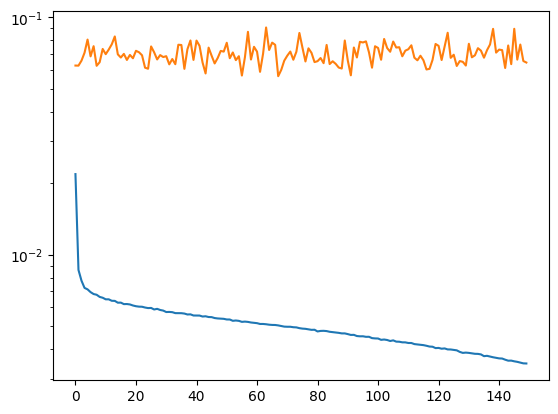

In [180]:
import matplotlib.pyplot as plt
plt.semilogy(epoch_loss_train)
plt.semilogy(epoch_loss_val)
print(epoch_loss_train[-1],epoch_loss_val[-1])

In [60]:
# torch.save(model.state_dict(),"model_mlp")
# model.load_state_dict(torch.load("model_general"))
# model = model.to(device)

In [181]:
### Deploying trained model on test dataset ###
train_predictions = list()
for i in range(len(train_inputs)):
    temp_input = torch.tensor(train_inputs[i,:][None,:]).cuda().float()
    train_predictions.append(model(temp_input))

train_predictions = torch.stack(train_predictions).detach().cpu().numpy()
train_results = np.concatenate((train_inputs,train_predictions[:,0]),axis=1)
train_results = scaler.inverse_transform(train_results)
train_results_pd = pd.DataFrame(np.concatenate( (train_results[:,[-4,-3,-1]],train_data_pd["Drag_local"].values[:,None]),axis=1)
                                ,columns=["Re","Phi","Pred","GT"])

R_2 =  0.8782298695700548


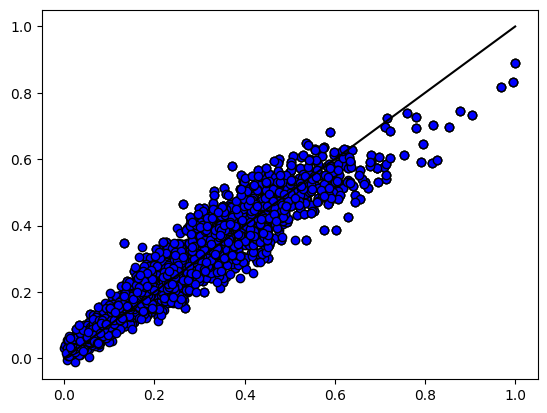

In [182]:
df_result = pd.DataFrame(np.concatenate((train_outputs,train_predictions[:,0]),axis=1),columns=["GT","Pred"])
plt.scatter(df_result["GT"].iloc[0:N],df_result["Pred"].iloc[0:N],c="blue",edgecolor='black')
plt.plot(np.linspace(0,df_result["GT"].iloc[0:N].max(),10),np.linspace(0,df_result["GT"].iloc[0:N].max(),10),c='black')
print("R_2 = ",str(r2_score(df_result["GT"].iloc[0:N].values,df_result["Pred"].iloc[0:N].values)) )

In [203]:
### Deploying trained model on test dataset ###
test_predictions = list()
for i in range(len(test_inputs)):
    temp_input = torch.tensor(test_inputs[i,:][None,:]).cuda().float()
    test_predictions.append(model(temp_input))

test_predictions = torch.stack(test_predictions).detach().cpu().numpy()

(480, 1, 1)

-0.503921294354061

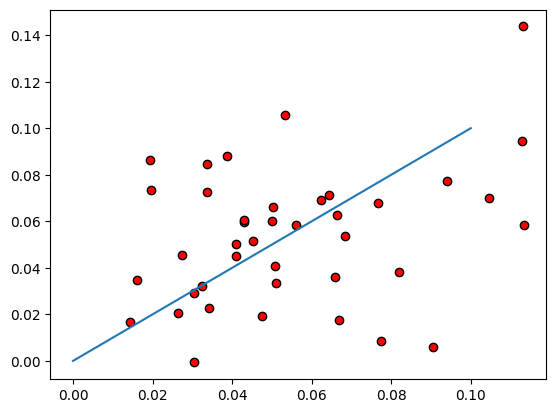

In [185]:
plt.scatter(test_outputs[0:40],test_predictions[0:40],c="red",edgecolor='black')
plt.plot(np.linspace(0,0.1,10),np.linspace(0,0.1,10))
r2_score(test_outputs[0:40],test_predictions[0:40,0])

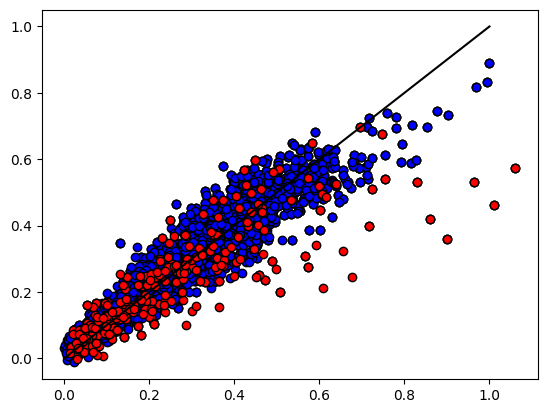

In [186]:
plt.scatter(train_outputs,train_predictions,c="blue",edgecolor='black')
plt.scatter(test_outputs,test_predictions,c="red",edgecolor='black')
plt.plot(np.linspace(0,1,10),np.linspace(0,1,10),c='black')

In [220]:
all_tags = np.load("ze_tags_2p5.npy")
all_tags_test = all_tags[test_indices]
final_result = pd.DataFrame( np.concatenate( (test_predictions[:,0],test_outputs,all_tags_test[:,2:]) ,axis=1),columns=["Pred","GT","Phi","Re"] )
final_result["rel_err"] = np.abs(final_result["GT"].values-final_result["Pred"].values)/final_result["GT"].values
final_result.groupby(["Phi","Re"]).mean()

Pred        GT   rel_err
Phi Re                                 
0.1 10.0   0.053313  0.054699  0.582134
    50.0   0.124618  0.123080  0.398700
    100.0  0.124618  0.123080  0.398700
    200.0  0.124618  0.123080  0.398700
0.2 10.0   0.159296  0.187583  0.260186
    50.0   0.270989  0.317048  0.225819
    100.0  0.270989  0.317048  0.225819
    200.0  0.270989  0.317048  0.225819
0.3 10.0   0.300510  0.350780  0.265016
    50.0   0.495425  0.573439  0.227456
    100.0  0.495425  0.573439  0.227456
    200.0  0.495425  0.573439  0.227456

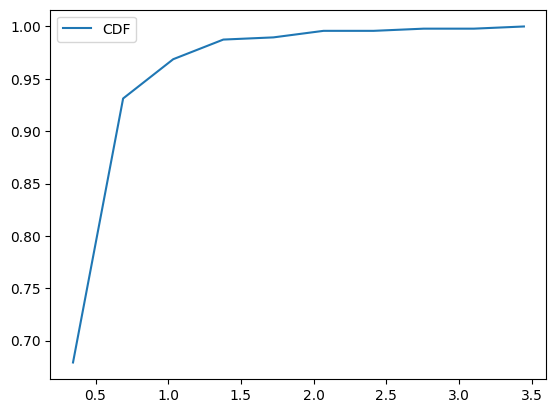

In [224]:
count, bins_count = np.histogram(final_result["rel_err"].values, bins=10) 
  
# finding the PDF of the histogram using count values 
pdf = count / sum(count) 
  
# using numpy np.cumsum to calculate the CDF 
# We can also find using the PDF values by looping and adding 
cdf = np.cumsum(pdf) 
  
# plotting PDF and CDF 
# plt.plot(bins_count[1:], pdf, color="red", label="PDF") 
plt.plot(bins_count[1:], cdf, label="CDF") 
plt.legend() 

In [ ]:
Re=10
Phi=30

test_subgroup = test_results_pd[(test_results_pd["Re"]==Re)&(test_results_pd["Phi"]==Phi)]
plt.scatter(test_subgroup["GT"],test_subgroup["Pred"],c="red",edgecolor='black')
plt.plot(np.linspace(test_subgroup["GT"].min(),test_subgroup["GT"].max(),10),
         np.linspace(test_subgroup["GT"].min(),test_subgroup["GT"].max(),10),c='black')
print(r2_score(test_subgroup["GT"].values,test_subgroup["Pred"].values))

In [ ]:
gt = test_subgroup["GT"].values
mean = np.ones(len(test_subgroup))*test_subgroup["GT"].values.mean()
pred = test_subgroup["Pred"].values

rel_err_mean = (np.abs(gt-mean)/(gt))*100
rel_err_pred = (np.abs(gt-pred)/(gt))*100
rel_err_mean.mean()

In [ ]:
rel_err_pred.mean()

Garbage

In [ ]:
# drags = np.concatenate( (all_data_pd["Drag_local"].values[0:207*4+402*4],
#                  all_data_pd[(all_data_pd["Re"]==10)&(all_data_pd["Phi"]==30)]["Drag_local"][0:549].values,
#                  all_data_pd[(all_data_pd["Re"]==50)&(all_data_pd["Phi"]==30)]["Drag_local"][0:549].values,
#                  all_data_pd[(all_data_pd["Re"]==100)&(all_data_pd["Phi"]==30)]["Drag_local"][0:549].values,
#                  all_data_pd[(all_data_pd["Re"]==200)&(all_data_pd["Phi"]==30)]["Drag_local"][0:549].values))
# drags

# np.save("ze_drags_2p5",all_data_pd["Drag_local"].values)